In [27]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import defaultdict

In [29]:
df=pd.read_csv('df_dec1_combined_airline.csv')

In [3]:
df.head()

,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,MKT_CARRIER,windows_tz_org,windows_tz_dest,addition_org,addition_dest,CRS_DEP_TIME_EST,CRS_ARR_TIME_EST,fema_region_org,fema_region_dest
0,AUS,DFW,1235,1344,10423,11298,AA,Central Standard Time,Central Standard Time,100,100,1335,1444,6.0,6.0
1,AUS,DFW,641,751,10423,11298,AA,Central Standard Time,Central Standard Time,100,100,741,851,6.0,6.0
2,AUS,DFW,846,957,10423,11298,AA,Central Standard Time,Central Standard Time,100,100,946,1057,6.0,6.0
3,AUS,DFW,1642,1751,10423,11298,AA,Central Standard Time,Central Standard Time,100,100,1742,1851,6.0,6.0
4,AUS,DFW,1032,1141,10423,11298,AA,Central Standard Time,Central Standard Time,100,100,1132,1241,6.0,6.0


In [8]:
df.columns

Index(['ORIGIN', 'DEST', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'ORIGIN_AIRPORT_ID',
       'DEST_AIRPORT_ID', 'MKT_CARRIER', 'windows_tz_org', 'windows_tz_dest',
       'addition_org', 'addition_dest', 'CRS_DEP_TIME_EST', 'CRS_ARR_TIME_EST',
       'fema_region_org', 'fema_region_dest'],
      dtype='object')

In [42]:
class cascade:
    def __init__(self,dur=100,dur_c=100,perc_c=0.25,t_start=800,airport='ATL',airline='DL'):
        self.dur=dur
        self.dur_c=dur_c
        self.perc_c=perc_c
        self.t_start=t_start
        self.airport=airport
        self.airline=airline
        
    def casairport(self,df):
        df1=df.loc[(df['CRS_DEP_TIME_EST']>=self.t_start) & (df['CRS_DEP_TIME_EST']<=2359) & \
              (df['CRS_ARR_TIME_EST']>=self.t_start) & (df['CRS_ARR_TIME_EST']<=2359)]
            
        df1['to_iterate']=0
        df1['iterated']=0
        df1.loc[(df1['ORIGIN']==self.airport) & (df1['CRS_DEP_TIME_EST']<=self.t_start+self.dur) & (df1['CRS_DEP_TIME_EST']>=self.t_start), 'to_iterate']=1
    
        cascade=[len(df1.loc[df1['to_iterate']==1 ])]
        c=0
        #while(cascade[len(cascade)-1]>0):
        while(cascade[len(cascade)-1]>0):
            for i in range(0, cascade[len(cascade)-1]):
    
                dest=df1[df1['to_iterate']==1]['DEST'][df1[df1['to_iterate']==1].index[i]] #choosing that destination airport where
                #perc_c fraction of flights impacted within same airline!
                time=df1[df1['to_iterate']==1]['CRS_ARR_TIME_EST'][df1[df1['to_iterate']==1].index[i]]#supposed time of arrival
                dest_air=df1[df1['to_iterate']==1]['MKT_CARRIER'][df1[df1['to_iterate']==1].index[i]]
            
                #propagation steps
                #choose those connecting flights corresponding to dest airport 
                a1=df1.loc[(df1['ORIGIN']==dest) & (df1['MKT_CARRIER']==dest_air) & (df1['CRS_DEP_TIME_EST']<=time+self.dur_c) & \
                        (df1['CRS_DEP_TIME_EST']>time) & (df1['CRS_ARR_TIME_EST']>=self.t_start+self.dur), 'to_iterate'].values
                w=np.where(a1==1)
            
                a2=np.random.choice([-1,0], len(df1.loc[(df1['ORIGIN']==dest) & (df1['MKT_CARRIER']==dest_air)&(df1['CRS_DEP_TIME_EST']<=time+self.dur_c) & \
                        (df1['CRS_DEP_TIME_EST']>time) & (df1['CRS_ARR_TIME_EST']>=self.t_start+self.dur) ]),\
                                    p=[self.perc_c, 1-self.perc_c])
                #only choosing those flights that are still running (to_iterate=0); as some might be disrupted from other flights
                #-1 so as to not compromise the loop (some number !=1)

                #corrected systematic logical errr: didnt take into account one flights connection could be another. Instead
                #I overstimated the impact by taking perc_c non-overlapping fractions!
                #corrected this by a1, a2 step and selecting minimum value to account for overlapping connections

                a2[w]=1
                #yet another caveat... make sure you don't iterate over previously iterated (to_iterate=1)
            
                df1.loc[(df1['ORIGIN']==dest) & (df1['MKT_CARRIER']==dest_air)& (df1['CRS_DEP_TIME_EST']<=time+self.dur_c) & \
                        (df1['CRS_DEP_TIME_EST']>time) & (df1['CRS_ARR_TIME_EST']>=self.t_start+self.dur), 'to_iterate']= \
                np.minimum(a1,a2)

            df1.loc[(df1['to_iterate']==1) & (df1['iterated']==0),'iterated']=1 #previously iterated added to 'iterated' list
            df1.loc[(df1['to_iterate']==1) & (df1['iterated']==1),'to_iterate']=0 #previously iterated removed from 'to_iterate' list
        
            df1.loc[(df1['to_iterate']==-1) & (df1['iterated']==0),'to_iterate']=1 #previously uniter airports to iterate added to'to_iter'
            cascade=np.r_[cascade,len(df1.loc[(df1['to_iterate']==1) & (df1['iterated']==0)])] #new airports to iterate added
            # to 'cascade'
    
            print(c,cascade[len(cascade)-2],cascade[len(cascade)-1])
            c+=1
        return(df1)
            
    def casairline(self,df):
        df1=df.loc[(df['CRS_DEP_TIME_EST']>=self.t_start) & (df['CRS_DEP_TIME_EST']<=2359) & \
              (df['CRS_ARR_TIME_EST']>=self.t_start) & (df['CRS_ARR_TIME_EST']<=2359)]
            
        df1['to_iterate']=0
        df1['iterated']=0
        df1.loc[(df1['MKT_CARRIER']==self.airline) & (df1['CRS_DEP_TIME_EST']<=self.t_start+self.dur) & (df1['CRS_DEP_TIME_EST']>=self.t_start), 'to_iterate']=1
    
        cascade=[len(df1.loc[df1['to_iterate']==1 ])]
        c=0
        #while(cascade[len(cascade)-1]>0):
        while(cascade[len(cascade)-1]>0):
            for i in range(0, cascade[len(cascade)-1]):
    
                dest=df1[df1['to_iterate']==1]['DEST'][df1[df1['to_iterate']==1].index[i]] #choosing that destination airport where
                #perc_c fraction of flights impacted within same airline!
                time=df1[df1['to_iterate']==1]['CRS_ARR_TIME_EST'][df1[df1['to_iterate']==1].index[i]]#supposed time of arrival
                dest_air=df1[df1['to_iterate']==1]['MKT_CARRIER'][df1[df1['to_iterate']==1].index[i]]
            
                #propagation steps
                #choose those connecting flights corresponding to dest airport 
                a1=df1.loc[(df1['ORIGIN']==dest) & (df1['MKT_CARRIER']==dest_air) & (df1['CRS_DEP_TIME_EST']<=time+self.dur_c) & \
                        (df1['CRS_DEP_TIME_EST']>time) & (df1['CRS_ARR_TIME_EST']>=self.t_start+self.dur), 'to_iterate'].values
                w=np.where(a1==1)
            
                a2=np.random.choice([-1,0], len(df1.loc[(df1['ORIGIN']==dest) & (df1['MKT_CARRIER']==dest_air)&(df1['CRS_DEP_TIME_EST']<=time+self.dur_c) & \
                        (df1['CRS_DEP_TIME_EST']>time) & (df1['CRS_ARR_TIME_EST']>=self.t_start+self.dur) ]),\
                                    p=[self.perc_c, 1-self.perc_c])
                #only choosing those flights that are still running (to_iterate=0); as some might be disrupted from other flights
                #-1 so as to not compromise the loop (some number !=1)

                #corrected systematic logical errr: didnt take into account one flights connection could be another. Instead
                #I overstimated the impact by taking perc_c non-overlapping fractions!
                #corrected this by a1, a2 step and selecting minimum value to account for overlapping connections

                a2[w]=1
                #yet another caveat... make sure I don't iterate over previously iterated (to_iterate=1)
            
                df1.loc[(df1['ORIGIN']==dest) & (df1['MKT_CARRIER']==dest_air)& (df1['CRS_DEP_TIME_EST']<=time+self.dur_c) & \
                        (df1['CRS_DEP_TIME_EST']>time) & (df1['CRS_ARR_TIME_EST']>=self.t_start+self.dur), 'to_iterate']= \
                np.minimum(a1,a2)

            df1.loc[(df1['to_iterate']==1) & (df1['iterated']==0),'iterated']=1 #previously iterated added to 'iterated' list
            df1.loc[(df1['to_iterate']==1) & (df1['iterated']==1),'to_iterate']=0 #previously iterated removed from 'to_iterate' list
        
            df1.loc[(df1['to_iterate']==-1) & (df1['iterated']==0),'to_iterate']=1 #previously uniter airports to iterate added to'to_iter'
            cascade=np.r_[cascade,len(df1.loc[(df1['to_iterate']==1) & (df1['iterated']==0)])] #new airports to iterate added
            # to 'cascade'
    
            print(c,cascade[len(cascade)-2],cascade[len(cascade)-1])
            c+=1
        return(df1)
            
    

In [43]:
p1 = cascade(100,100,0.25,800)
df1=p1.casairport(df)

C:\Users\Skanda\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\Skanda\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Skanda\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

0 94 73
1 73 286
2 286 344
3 344 435
4 435 257
5 257 57
6 57 1
7 1 0


Text(0.5, 1.0, '8-9 AM shutdown of DL')

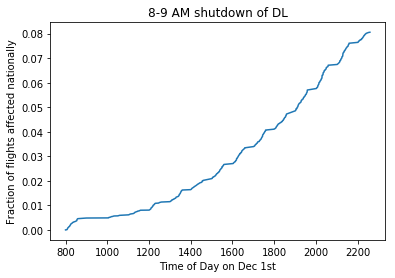

In [48]:
del_df=df1.loc[(df1['iterated']==1)] #this gives all flights that have been impacted in df1 list
delays=del_df.groupby(['CRS_DEP_TIME_EST']).size().values
indices=del_df.groupby(['CRS_DEP_TIME_EST']).size().index
d=np.cumsum(delays) 
i=indices
plt.plot(i,d/len(df1),label='national')
plt.ylabel('Fraction of flights affected nationally')
plt.xlabel('Time of Day on Dec 1st')
plt.title('8-9 AM shutdown of DL')